# Identifying Pathology in Chest X-Rays

## Business Justification

* Improve medical diagnostic technology and make it more accessible (less need for physicians)

In [20]:
from IPython.core.display import display, HTML
display(HTML(r"""<style id=hide>div.input{display:none;}</style><button type="button"onclick="var myStyle = document.getElementById('hide').sheet;myStyle.insertRule('div.input{display:inherit !important;}', 0);">Show inputs</button>"""))

In [1]:
import cv2
import os
import random
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from ipywidgets import widgets,interact, interactive, fixed, interact_manual
import numpy as np
import keras 
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from ipywidgets import widgets,interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output, Markdown, Image
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load json and create model
balanced_mlp = open('balanced_mlp_model.json', 'r')
balanced_mlp_json = balanced_mlp.read()
balanced_mlp.close()
balanced_mlp_model = model_from_json(balanced_mlp_json)
# load weights into new model
balanced_mlp_model.load_weights("balanced_mlp_model.h5")

# load json and create model
ros_mlp = open('ros_mlp_model.json', 'r')
ros_mlp_json = ros_mlp.read()
ros_mlp.close()
ros_mlp_model = model_from_json(ros_mlp_json)
# load weights into new model
ros_mlp_model.load_weights("ros_mlp_model.h5")

# load json and create model
ros_cnn = open('ros_cnn.json', 'r')
ros_cnn_json = ros_cnn.read()
ros_cnn.close()
ros_cnn_model = model_from_json(ros_cnn_json)
# load weights into new model
ros_cnn_model.load_weights("model.h5")


In [3]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load disease labels
y_npz = np.load("y_disease_labels.npz")
y = y_npz['arr_0']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
X_train_reshape = X_train.reshape(X_train.shape[0], -1).astype('float32')
X_test_reshape = X_test.reshape(X_test.shape[0], -1).astype('float32')
#one-hot encode y_train & y_test
y_trainHot = keras.utils.to_categorical(y_train, 8)
y_testHot = keras.utils.to_categorical(y_test, 8)

In [5]:
# ../input/
PATH = os.path.abspath(os.path.join('input'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('input/sample_labels.csv')

## Process Overview

* Exploratory data analysis 
* Feed-forward neural networks (MLP) with class weights and random over-sampling
* Convolutional neural networks with class weights, random over-sampling, data augmentation
* Transfer learning (vgg19) 

**Meta-Analysis**
* Binary disease classification (disease Y/N)

## Exploratory Data Analysis

### Sample X-Ray Images by Disease

Select a pathology to see a sample representative image.

In [7]:
infiltration = cv2.imread(os.path.join(SOURCE_IMAGES,'00030209_008.png'))
no_finding = cv2.imread(os.path.join(SOURCE_IMAGES,'00000017_001.png'))
atelectasis = cv2.imread(os.path.join(SOURCE_IMAGES,'00000030_001.png'))
effusion = cv2.imread(os.path.join(SOURCE_IMAGES,'00000061_002.png'))
mass = cv2.imread(os.path.join(SOURCE_IMAGES,'00000079_000.png'))
consolidation = cv2.imread(os.path.join(SOURCE_IMAGES,'00030636_012.png'))
pneumothorax = cv2.imread(os.path.join(SOURCE_IMAGES,'00022668_000.png'))
hernia = cv2.imread(os.path.join(SOURCE_IMAGES,'00007352_000.png'))
pneumonia = cv2.imread(os.path.join(SOURCE_IMAGES,'00028924_005.png'))
fibrosis = cv2.imread(os.path.join(SOURCE_IMAGES,'00004048_012.png'))
edema = cv2.imread(os.path.join(SOURCE_IMAGES,'00027782_002.png'))
emphysema = cv2.imread(os.path.join(SOURCE_IMAGES,'00029981_002.png'))
cardiomegaly = cv2.imread(os.path.join(SOURCE_IMAGES,'00029510_000.png'))
pleural_thickening = cv2.imread(os.path.join(SOURCE_IMAGES,'00028505_012.png'))
nodule = cv2.imread(os.path.join(SOURCE_IMAGES,'00030301_000.png'))

#Peak Active time
def check_pathology(pathology):
    if pathology=='Infiltration':
        return infiltration
    elif pathology=='No Finding':
        return no_finding
    elif pathology=='Atelectasis':
        return atelectasis
    elif pathology=='Effusion':
        return effusion
    elif pathology=='Mass':
        return mass
    elif pathology=='Consolidation':
        return consolidation
    elif pathology=='Hernia':
        return hernia
    elif pathology=='Pneumonia':
        return pneumonia
    elif pathology=='Fibrosis':
        return fibrosis
    elif pathology=='Edema':
        return edema
    elif pathology=='Emphysema':
        return emphysema
    elif pathology=='Cardiomegaly':
        return cardiomegaly
    elif pathology=='Pleural Thickening':
        return pleural_thickening
    elif pathology=='Nodule':
        return nodule
    elif pathology=='Pneumothorax':
        return pneumothorax
    
def generate_xray(pathology):
    xray = check_pathology(pathology)
    return plt.imshow(xray)
interact(generate_xray, pathology=['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 
                              'Pleural Thickening','Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 
                              'Effusion', 'Infiltration','No Finding'])


interactive(children=(Dropdown(description='pathology', options=('Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'â€¦

<function __main__.generate_xray(pathology)>

In [8]:
#Cleaning Dataset
df = labels
single = df[df['Finding Labels'].map(lambda x: "|" not in str(x))]
multiple = df[df['Finding Labels'].map(lambda x: "|" in str(x))]
# len(multiple[multiple['Finding Labels']=='Infiltration'])

### Single vs. Multiple Pathologies

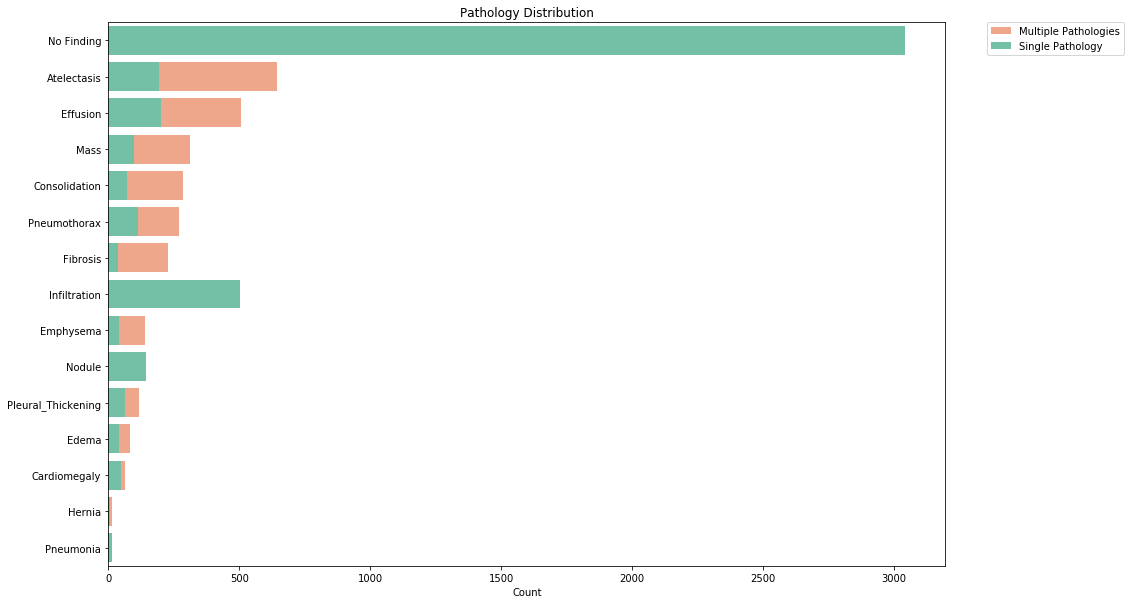

In [9]:
def path_count(pathology):
    if "|" not in pathology:
        return 0
    else:
        return 1

def multiple_count(pathology_column):
    return pathology_column.map(lambda x: path_count(x))

df['Multiple'] = multiple_count(df['Finding Labels'])

pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis',
                  'Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list:
    df[pathology] = df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data1 = pd.melt(df,
             id_vars=['Multiple'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
p=sns.countplot(y='Category',data=data1, 
                order = data1['Category'].value_counts().index,ax=ax,color='lightsalmon',label="Multiple Pathologies")
p=sns.countplot(y='Finding Labels',data=single, ax=ax, color="mediumaquamarine",label="Single Pathology")
ax.set_title('Pathology Distribution')
ax.set_ylabel('')
ax.set_xlabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Single Pathology Distribution by Gender 

In [10]:
def clean_age(age):
    if 'Y' not in age:
        age = '0'
    else:
        age = age
    clean_age = ''.join(i for i in age if i.isdigit())
    return int(clean_age)

def clean_all_ages(age_column):
    return age_column.map(lambda x: clean_age(x))

single['Patient Age'] = clean_all_ages(single['Patient Age'])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


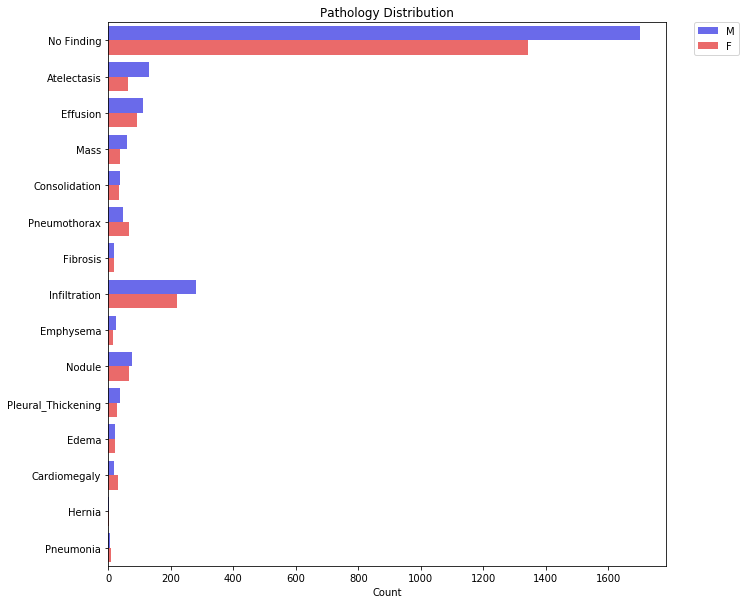

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(y="Finding Labels", hue="Patient Gender", data=single, palette='seismic')
ax.set_title('Pathology Distribution')
ax.set_ylabel('')
ax.set_xlabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Single Pathology Distribution, by Patient Age

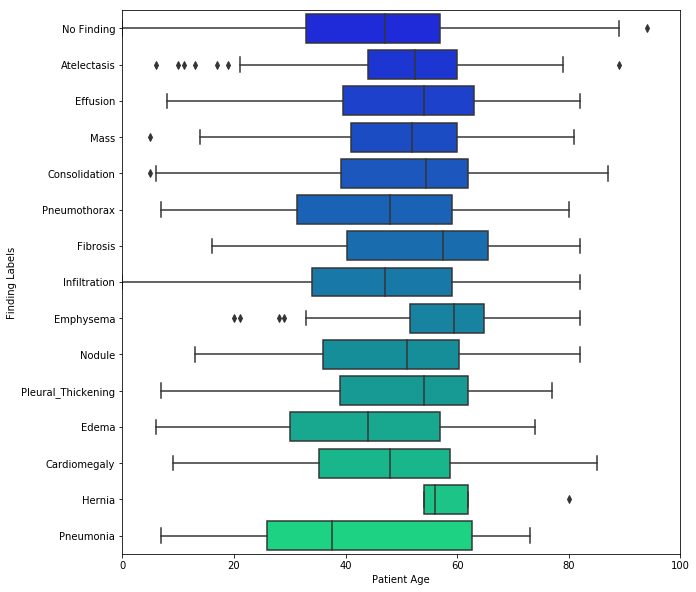

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
plt.xlim(0, 100)
ax = sns.boxplot(y='Finding Labels',x='Patient Age',data=single,palette='winter')

## Data Cleaning

* Images resized from 1024x1024 to 128x128
* Eliminate x-rays with multiple pathologies
* Rare diseases grouped together

## Labels

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5,1,'Pathology Distribution')

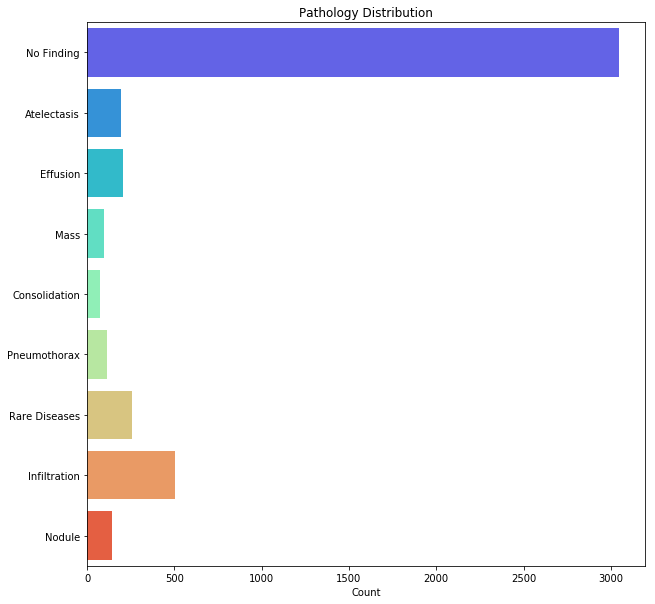

In [13]:
clean_df = single
RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"] #7

clean_df['Finding Labels'] = clean_df['Finding Labels'].apply(lambda x: 'Rare Diseases' if x in RareClass else x)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(y="Finding Labels", data=clean_df, palette='rainbow')
ax.set_ylabel('')
ax.set_xlabel('Count')
ax.set_title('Pathology Distribution')

In [15]:
test = clean_df[clean_df['Finding Labels']=='No Finding']
len(test)

3044

## Class Imbalance Solutions

#### Class Weights

* Class weights were passed into model.fit()

In [14]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.1858984888304862,
 1: 7.859375,
 2: 1.125,
 3: 4.963815789473684,
 4: 2.7875615763546797,
 5: 3.9296875,
 6: 2.947265625,
 7: 2.2191176470588236}

#### Random Over-Sampling
* Randomly oversampled data to increase sample size

#### Data Augmentation
* Horizontally flipped images and rotated by 30 degrees to add more images to sample

## Hyperparameters

In [15]:
epochs=5
optimizer=optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001)
batch_size=32
loss='categorical_crossentropy'
activation='relu'
out_activation='softmax'

* Optimizer: Adam (learning rate: 0.000001, decay=0.0000001)
* Batch Size = 32 
* Loss = Categorical Cross-Entropy
* Activation = relu
* Output Activation = Softmax

## Multilayer Perceptron

### Balanced Class Weights

#### Architecture

In [16]:
#architecture and hyperparameters
balanced_mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               7372950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 125)               18875     
_________________________________________________________________
dropout_2 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               12600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 75)                7575      
__________

![Balanced Accuracy Diagram](balanced_mlp.png "Balanced MLP Accuracy")

### Random Oversampling

#### Architecture

In [17]:
ros_mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               4915300   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                2525      
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650       
__________

![ROS Accuracy Diagram](ros_mlp.png "ROS MLP Accuracy")

## Convolutional Neural Networks

#### Architecture 

In [18]:
ros_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
__________

![ROS Accuracy Diagram](ros_cnn.png "ROS MLP Accuracy")

## Conclusions

### Limitations 

#### Label Accuracy 
*Source: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/*
* Labels were produced, using text mining (from clinical reports connected with the images)
* Cross-validation of labels based on two annotators who looked at the reports (but not the images)
* Based on this process, label accuracy was >90%
* Actual label accuracy, based on the images alone (radiologist-labeled), was much lower

![Label Accuracy Diagram](label_accuracy.png "Label Accuracy")

![False Atelectasis Diagram](false_atelectasis.png "Label Accuracy")

### Treated Pneumothorax

![Label Accuracy Diagram](treated_pneumothorax.png "Label Accuracy")

### With a pre-trained model

**True Positives**

![Label Accuracy Diagram](true_pos.png "Label Accuracy")

**False Negatives**

![Label Accuracy Diagram](false_neg.png "Label Accuracy")

* Data flawed, with internally inconsistent labels 
* Models only trained to fit on these images so they're essentially fitting on noise -- any predictions would be nonsensical
* Because data is flawed with lots of noise, we had many issues with validation loss and accuracy in spite of hyperparameter tuning (this persisted even with binary classification -- disease Y/N)

## Next Steps

* ALWAYS CHECK DATA QUALITY
* Work with better datasets
* Include other parameters (patient age, gender)

## Random Image Generator

In [19]:
# produce random image, prediction, and actual label 

def pathology_label(val):
    pathology_dict = {0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 
                      4:'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: "Other Rare Classes"}
    return [v for k, v in pathology_dict.items() if k==val][0]

def make_prediction():
    rand_image = single.sample(1)
    img_index = rand_image['Image Index'].tolist()[0]
    img = cv2.imread(os.path.join(SOURCE_IMAGES, img_index))
    img_pathology = rand_image['Finding Labels'].tolist()[0]
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC)
    test_img = img_to_array(img)
    test_img = test_img.reshape(-1).astype('float32')
    test_img = np.expand_dims(test_img, axis = 0)
    y_prob = ros_mlp_model.predict(test_img)
    y_classes = y_prob.argmax(axis=-1)[0]
    prediction = pathology_label(y_classes)
    print("Randomly generated image is labeled as: " + img_pathology + 
          ". The model has predicted the pathology to be: " + prediction + ".")
    return img
    
out=widgets.Output()
button=widgets.Button(description='Generate X-Ray!')
vbox=widgets.VBox(children=(out,button))
display(vbox)

def on_button_clicked(b):
    with out:
        clear_output(wait=True)
        img = make_prediction()
        plt.imshow(img)
        show_inline_matplotlib_plots()

button.on_click(on_button_clicked)